In [1]:
import torch
import torchvision
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import torch.nn as nn
import torchvision.models as models
import torch.nn.functional as F
from torch.utils.data import DataLoader, random_split
import torch.optim as optim
from torch.optim.lr_scheduler import ReduceLROnPlateau
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import time
import numpy as np 


In [2]:
# Load the training dataset
train_dataset = datasets.CIFAR10(root='./data', train=True, download=True, transform=transforms.ToTensor())

# Create a DataLoader with batch_size equal to the size of the dataset
train_loader = DataLoader(train_dataset, batch_size=len(train_dataset), shuffle=False)

# Get all the data in one batch
data_iter = iter(train_loader)
images, _ = next(data_iter) 

# Calculate mean and std over batch, channel, height, and width
mean = images.mean(dim=[0, 2, 3]) #0 is the batch dimension, 2 is the height dimension, 3 is the width dimension
std = images.std(dim=[0, 2, 3])

# Convert mean and std tensors to lists
mean = mean.tolist()
std = std.tolist()

for i in range(len(mean)):
    mean[i]= round(mean[i],4)
    std[i]=round(std[i],4)

print(f'Mean: {mean}')
print(f'Std: {std}')

Files already downloaded and verified
Mean: [0.4914, 0.4822, 0.4465]
Std: [0.247, 0.2435, 0.2616]


In [3]:
# Define transformations for training and testing
transform_train = transforms.Compose([
    transforms.RandomCrop(32, padding=4, padding_mode='reflect'),  # Randomly crops the image to a size of 32x32 pixels, Pads with 4 on each side
    transforms.RandomHorizontalFlip(),     #Randomly flips the image horizontally with a default probability of 0.5
    transforms.ToTensor(),                 #Normalise the pixel values to [0,1]
    transforms.Normalize(mean,std)
])

transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean, std)
])

# Load the datasets
trainset_full = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform_train)
testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform_test)


Files already downloaded and verified
Files already downloaded and verified


In [4]:
def CIFAR10_ResNet18():
    resnet18 = models.resnet18(weights='DEFAULT')

    # Modify the first convolutional layer
    resnet18.conv1 = nn.Conv2d(
        in_channels=3,
        out_channels=64,
        kernel_size=3,
        stride=1,
        padding=1,
        bias=False
    )
    nn.init.kaiming_normal_(resnet18.conv1.weight, mode='fan_out', nonlinearity='relu')

    # Remove the max-pooling layer
    resnet18.maxpool = nn.Identity()

    # Modify the fully connected layer
    resnet18.fc = nn.Linear(resnet18.fc.in_features, 10)   # 10 classes for CIFAR-10
    nn.init.xavier_normal_(resnet18.fc.weight)
    nn.init.constant_(resnet18.fc.bias, 0)

    return resnet18

# Instantiate the model
resnet18 = CIFAR10_ResNet18()

In [5]:
#AlexNet
class CIFAR10_AlexNet(nn.Module):
    def __init__(self):
        super(CIFAR10_AlexNet, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1),  # Conv Layer 1
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),                 # Max Pooling Layer 1

            nn.Conv2d(64, 192, kernel_size=3, stride=1, padding=1),  # Conv Layer 2
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),                   # Max Pooling Layer 2

            nn.Conv2d(192, 384, kernel_size=3, stride=1, padding=1),  # Conv Layer 3
            nn.ReLU(inplace=True),

            nn.Conv2d(384, 256, kernel_size=3, stride=1, padding=1),  # Conv Layer 4
            nn.ReLU(inplace=True),

            nn.Conv2d(256, 256, kernel_size=3, stride=1, padding=1),  # Conv Layer 5
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2)                     # Max Pooling Layer 3
        )

        # Calculate the input features for the first fully connected layer
        self._initialize_weights()
        self.num_flat_features = self._get_num_flat_features()

        # Fully Connected Layers
        self.classifier = nn.Sequential(
            nn.Dropout(p=0.5),
            nn.Linear(self.num_flat_features, 4096),   # FC Layer 1
            nn.ReLU(inplace=True),

            nn.Dropout(p=0.5),
            nn.Linear(4096, 4096),                     # FC Layer 2
            nn.ReLU(inplace=True),

            nn.Linear(4096, 10)                        # FC Layer 3 (Output Layer)
        )

    def forward(self, x):
        x = self.features(x)
        x = x.view(x.size(0), -1)  # Flatten
        x = self.classifier(x)
        return x

    def _get_num_flat_features(self):
        # Pass a dummy input through the features to get the output size
        with torch.no_grad():
            dummy_input = torch.zeros(1, 3, 32, 32)
            output_feat = self.features(dummy_input)
            num_features = output_feat.view(1, -1).size(1)
        return num_features

    def _initialize_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                # He initialisation for Conv layers
                nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
                if m.bias is not None: 
                    nn.init.constant_(m.bias, 0)       #If biases are present, they are initialised to zero
            elif isinstance(m, nn.Linear):
                # Xavier initialisation for FC layers
                nn.init.xavier_normal_(m.weight)
                nn.init.constant_(m.bias, 0)

# Instantiate the model
alexnet = CIFAR10_AlexNet()

In [6]:
# Define batch size
batch_size = 128

# Split the training data into training and validation sets
train_size = int(0.9 * len(trainset_full))
val_size = len(trainset_full) - train_size
trainset, valset = random_split(trainset_full, [train_size, val_size])

# Create iterable objects for each dataset through DatdaLoader
train_loader = DataLoader(trainset, batch_size=batch_size, shuffle=True, num_workers=2)
val_loader = DataLoader(valset, batch_size=batch_size, shuffle=False, num_workers=2)
test_loader = DataLoader(testset, batch_size=batch_size, shuffle=False, num_workers=2)

In [7]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
alexnet.to(device)
resnet18.to(device)

#Cross-Entropy Loss
criterion = nn.CrossEntropyLoss() 

#Adam for AlexNet
optimiser_alexnet = optim.Adam(alexnet.parameters(), lr=0.001, weight_decay=5e-4)

#Adam for ResNet-18
optimiser_resnet = optim.Adam(resnet18.parameters(), lr=0.001, weight_decay=5e-4)

# Scheduler for AlexNet
scheduler_alexnet = ReduceLROnPlateau(optimiser_alexnet, mode='min', factor=0.1, patience=5)

# Scheduler for ResNet-18
scheduler_resnet = ReduceLROnPlateau(optimiser_resnet, mode='min', factor=0.1, patience=5)

In [8]:
def train(model, dataloader, optimiser, criterion, device):
    model.train()  # Set model to training mode
    running_loss = 0.0
    correct = 0
    total = 0
    total_grad_norm = 0.0
    num_batches = 0

    for inputs, labels in dataloader:
        # Move data to the device
        inputs, labels = inputs.to(device), labels.to(device)
        
        
        # Zero the parameter gradients
        optimiser.zero_grad()
        
        # Forward pass
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        
        # Backward pass and optimisation
        loss.backward()
        optimiser.step()
        
        # Accumulate loss and accuracy
        running_loss += loss.item() * inputs.size(0)
        _, predicted = outputs.max(1)
        total += labels.size(0)
        correct += predicted.eq(labels).sum().item()
        
         # Compute gradient norms
        total_norm = 0.0
        for p in model.parameters():
            if p.grad is not None:
                param_norm = p.grad.data.norm(2)
                total_norm += param_norm.item() ** 2
        total_grad_norm += total_norm ** 0.5
        num_batches += 1
    
    epoch_loss = running_loss / total
    epoch_accuracy = correct / total
    avg_grad_norm = total_grad_norm / num_batches
    return epoch_loss, epoch_accuracy, avg_grad_norm

In [9]:
def validate(model, dataloader, criterion, device):
    model.eval()  # Set model to evaluation mode
    running_loss = 0.0
    correct = 0
    total = 0

    with torch.no_grad():
        for inputs, labels in dataloader:
            inputs, labels = inputs.to(device), labels.to(device)
            
            # Forward pass
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            
            # Accumulate loss and accuracy
            running_loss += loss.item() * inputs.size(0)
            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()
    
    epoch_loss = running_loss / total
    epoch_accuracy = correct / total
    return epoch_loss, epoch_accuracy

In [10]:
def imshow(img, mean, std):
    img = img * torch.tensor(std).view(3,1,1) + torch.tensor(mean).view(3,1,1)  # Unnormalize
    img = img.numpy()
    img = np.transpose(img, (1, 2, 0))  # Convert from (C, H, W) to (H, W, C)
    plt.imshow(img)
    plt.axis('off')

In [11]:
def get_all_preds(model, dataloader, device):
    model.eval()
    all_preds = []
    all_labels = []
    
    with torch.no_grad():
        for inputs, labels in dataloader:
            inputs = inputs.to(device)
            outputs = model(inputs)
            _, preds = outputs.max(1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.numpy())
    return all_labels, all_preds

In [12]:
num_epochs = 50

# Lists to store training and validation metrics
train_losses_alexnet = []
val_losses_alexnet = []
train_accuracies_alexnet = []
val_accuracies_alexnet = []

train_losses_resnet = []
val_losses_resnet = []
train_accuracies_resnet = []
val_accuracies_resnet = []

# Variables to keep track of the best validation accuracy
best_val_accuracy_alexnet = 0.0
best_val_accuracy_resnet = 0.0

lr_rates_alexnet = []
lr_rates_resnet = []

# Store Gradient Norms
grad_norms_alexnet = []
grad_norms_resnet = []

for epoch in range(num_epochs):
    start_time = time.time()  # Start time
    print(f'Epoch {epoch+1}/{num_epochs}')
    print('-' * 30)
    
    # Train AlexNet
    train_loss_alexnet, train_accuracy_alexnet, grad_norm_alexnet = train(
        alexnet, train_loader, optimiser_alexnet, criterion, device
    )
    grad_norms_alexnet.append(grad_norm_alexnet)
    
    # Validate AlexNet
    val_loss_alexnet, val_accuracy_alexnet = validate(
        alexnet, val_loader, criterion, device
    )
    
    # Update scheduler for AlexNet
    scheduler_alexnet.step(val_loss_alexnet)
    current_lr_alexnet = optimiser_alexnet.param_groups[0]['lr']
    lr_rates_alexnet.append(current_lr_alexnet)
    
    # Store metrics
    train_losses_alexnet.append(train_loss_alexnet)
    val_losses_alexnet.append(val_loss_alexnet)
    train_accuracies_alexnet.append(train_accuracy_alexnet)
    val_accuracies_alexnet.append(val_accuracy_alexnet)
    
    # Save the best model based on validation accuracy
    if val_accuracy_alexnet > best_val_accuracy_alexnet:
        best_val_accuracy_alexnet = val_accuracy_alexnet
        torch.save(alexnet.state_dict(), 'best_alexnet.pth')
    
    print(f'AlexNet - Train Loss: {train_loss_alexnet:.4f}, Train Acc: {train_accuracy_alexnet:.4f}')
    print(f'AlexNet - Val Loss: {val_loss_alexnet:.4f}, Val Acc: {val_accuracy_alexnet:.4f}')
    print()
    
    # Train ResNet-18
    train_loss_resnet, train_accuracy_resnet, grad_norm_resnet = train(resnet18, train_loader, optimiser_resnet, criterion, device)
    grad_norms_resnet.append(grad_norm_resnet)
    
    # Validate ResNet-18
    val_loss_resnet, val_accuracy_resnet = validate(
        resnet18, val_loader, criterion, device
    )
    
    # Update scheduler for ResNet-18
    scheduler_resnet.step(val_loss_resnet)
    current_lr_resnet = optimiser_resnet.param_groups[0]['lr']
    lr_rates_resnet.append(current_lr_resnet)
    
    # Store metrics
    train_losses_resnet.append(train_loss_resnet)
    val_losses_resnet.append(val_loss_resnet)
    train_accuracies_resnet.append(train_accuracy_resnet)
    val_accuracies_resnet.append(val_accuracy_resnet)
    
    # Save the best ResNet-18 model based on validation accuracy
    if val_accuracy_resnet > best_val_accuracy_resnet:
        best_val_accuracy_resnet = val_accuracy_resnet
        torch.save(resnet18.state_dict(), 'best_resnet18.pth')
        
    epoch_time = time.time() - start_time  # Calculate epoch duration
    print(f'ResNet-18 - Train Loss: {train_loss_resnet:.4f}, Train Acc: {train_accuracy_resnet:.4f}')
    print(f'ResNet-18 - Val Loss: {val_loss_resnet:.4f}, Val Acc: {val_accuracy_resnet:.4f}')
    print(f'Epoch {epoch+1} completed in {epoch_time:.2f} seconds')
    print('=' * 30)


Epoch 1/50
------------------------------
AlexNet - Train Loss: 1.6987, Train Acc: 0.3511
AlexNet - Val Loss: 1.4132, Val Acc: 0.4670

ResNet-18 - Train Loss: 0.8934, Train Acc: 0.6990
ResNet-18 - Val Loss: 0.6801, Val Acc: 0.7672
Epoch 1 completed in 22.71 seconds
Epoch 2/50
------------------------------
AlexNet - Train Loss: 1.3112, Train Acc: 0.5231
AlexNet - Val Loss: 1.2284, Val Acc: 0.5512

ResNet-18 - Train Loss: 0.5284, Train Acc: 0.8205
ResNet-18 - Val Loss: 0.5905, Val Acc: 0.7990
Epoch 2 completed in 22.65 seconds
Epoch 3/50
------------------------------
AlexNet - Train Loss: 1.1090, Train Acc: 0.6008
AlexNet - Val Loss: 0.9676, Val Acc: 0.6408

ResNet-18 - Train Loss: 0.4581, Train Acc: 0.8454
ResNet-18 - Val Loss: 0.5681, Val Acc: 0.8106
Epoch 3 completed in 22.53 seconds
Epoch 4/50
------------------------------
AlexNet - Train Loss: 0.9803, Train Acc: 0.6532
AlexNet - Val Loss: 0.9028, Val Acc: 0.6894

ResNet-18 - Train Loss: 0.4321, Train Acc: 0.8542
ResNet-18 - Val L

In [13]:
# Load the best saved models
alexnet.load_state_dict(torch.load('best_alexnet.pth'))
resnet18.load_state_dict(torch.load('best_resnet18.pth'))


<All keys matched successfully>

In [14]:
test_loss_alexnet, test_accuracy_alexnet = validate(
    alexnet, test_loader, criterion, device
)
print(f'AlexNet Test Loss: {test_loss_alexnet:.4f}, Test Accuracy: {test_accuracy_alexnet:.4f}')

AlexNet Test Loss: 0.3826, Test Accuracy: 0.8777


In [15]:
test_loss_resnet, test_accuracy_resnet = validate(
    resnet18, test_loader, criterion, device
)
print(f'ResNet-18 Test Loss: {test_loss_resnet:.4f}, Test Accuracy: {test_accuracy_resnet:.4f}')

ResNet-18 Test Loss: 0.2240, Test Accuracy: 0.9331


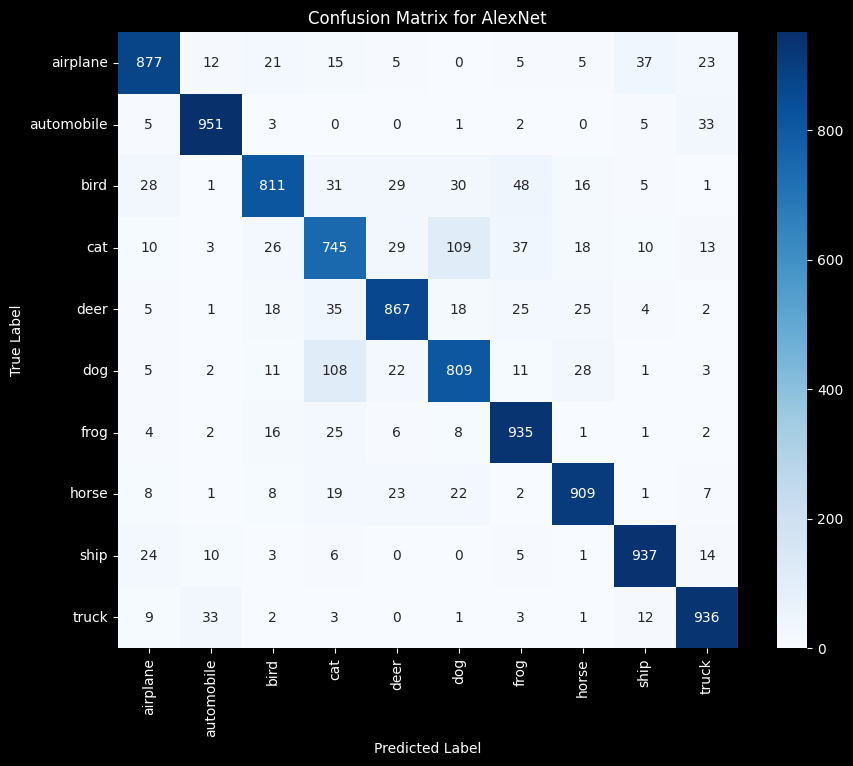

In [16]:
# Define class names
class_names = testset.classes

# Get predictions and true labels for AlexNet
y_true_alexnet, y_pred_alexnet = get_all_preds(alexnet, test_loader, device)

# Compute confusion matrix
cm_alexnet = confusion_matrix(y_true_alexnet, y_pred_alexnet)

# Plot confusion matrix for AlexNet
plt.figure(figsize=(10, 8))
sns.heatmap(cm_alexnet, annot=True, fmt='d', xticklabels=class_names, yticklabels=class_names, cmap='Blues')
plt.title('Confusion Matrix for AlexNet')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()

In [17]:
# For AlexNet
print('Classification Report for AlexNet:')
print(classification_report(y_true_alexnet, y_pred_alexnet, target_names=class_names))

Classification Report for AlexNet:
              precision    recall  f1-score   support

    airplane       0.90      0.88      0.89      1000
  automobile       0.94      0.95      0.94      1000
        bird       0.88      0.81      0.85      1000
         cat       0.75      0.74      0.75      1000
        deer       0.88      0.87      0.88      1000
         dog       0.81      0.81      0.81      1000
        frog       0.87      0.94      0.90      1000
       horse       0.91      0.91      0.91      1000
        ship       0.92      0.94      0.93      1000
       truck       0.91      0.94      0.92      1000

    accuracy                           0.88     10000
   macro avg       0.88      0.88      0.88     10000
weighted avg       0.88      0.88      0.88     10000



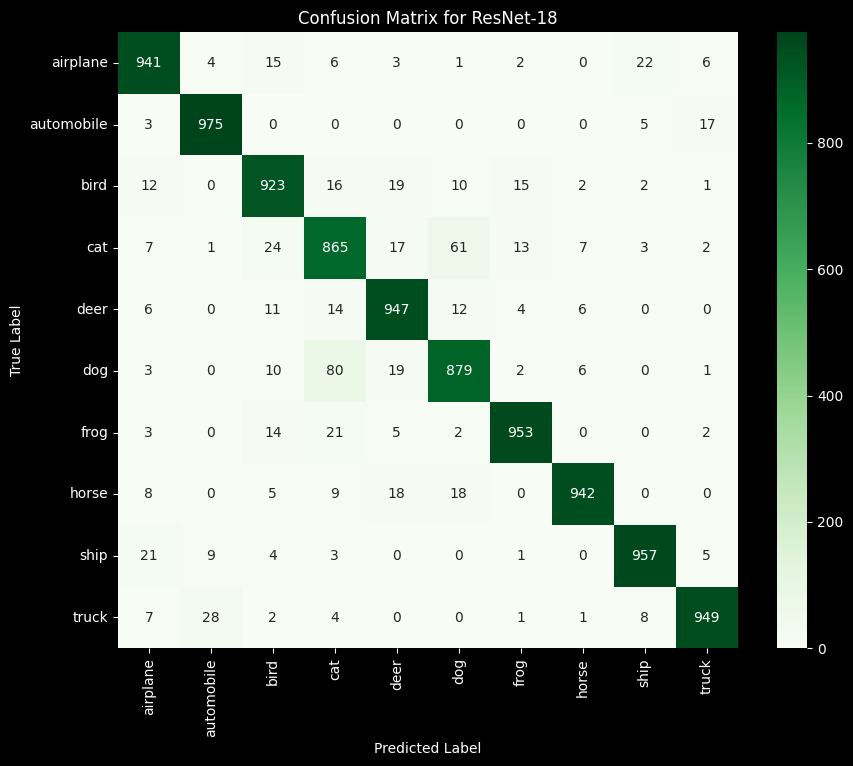

In [18]:
# Get predictions and true labels for ResNet-18
y_true_resnet, y_pred_resnet = get_all_preds(resnet18, test_loader, device)

# Compute confusion matrix
cm_resnet = confusion_matrix(y_true_resnet, y_pred_resnet)

# Plot confusion matrix for ResNet-18
plt.figure(figsize=(10, 8))
sns.heatmap(cm_resnet, annot=True, fmt='d', xticklabels=class_names, yticklabels=class_names, cmap='Greens')
plt.title('Confusion Matrix for ResNet-18')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()


In [19]:
# For ResNet-18
print('Classification Report for ResNet-18:')
print(classification_report(y_true_resnet, y_pred_resnet, target_names=class_names))

Classification Report for ResNet-18:
              precision    recall  f1-score   support

    airplane       0.93      0.94      0.94      1000
  automobile       0.96      0.97      0.97      1000
        bird       0.92      0.92      0.92      1000
         cat       0.85      0.86      0.86      1000
        deer       0.92      0.95      0.93      1000
         dog       0.89      0.88      0.89      1000
        frog       0.96      0.95      0.96      1000
       horse       0.98      0.94      0.96      1000
        ship       0.96      0.96      0.96      1000
       truck       0.97      0.95      0.96      1000

    accuracy                           0.93     10000
   macro avg       0.93      0.93      0.93     10000
weighted avg       0.93      0.93      0.93     10000



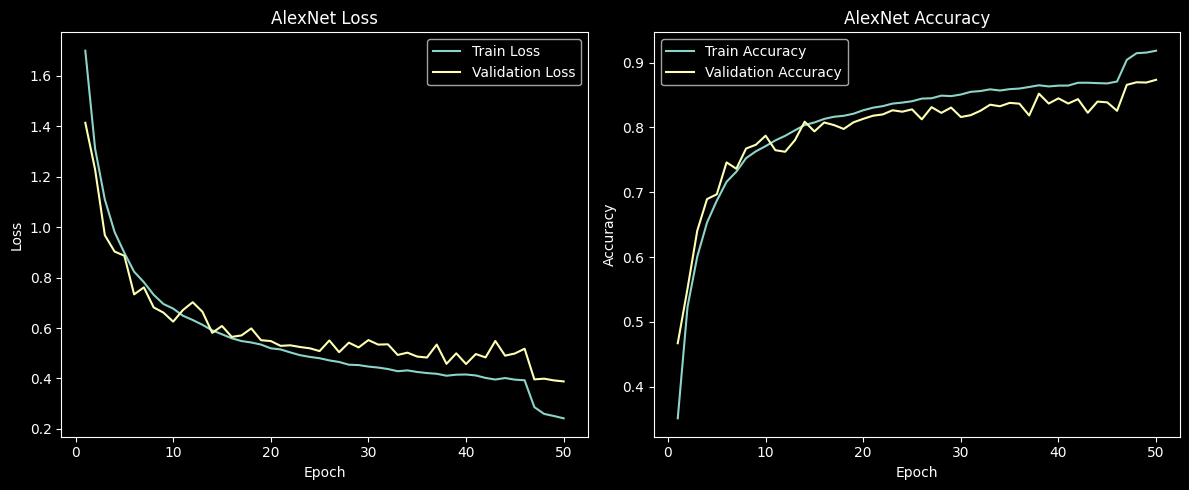

In [20]:
epochs = range(1, num_epochs + 1)

# Plot Loss
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(epochs, train_losses_alexnet, label='Train Loss')
plt.plot(epochs, val_losses_alexnet, label='Validation Loss')
plt.title('AlexNet Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

# Plot Accuracy
plt.subplot(1, 2, 2)
plt.plot(epochs, train_accuracies_alexnet, label='Train Accuracy')
plt.plot(epochs, val_accuracies_alexnet, label='Validation Accuracy')
plt.title('AlexNet Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()


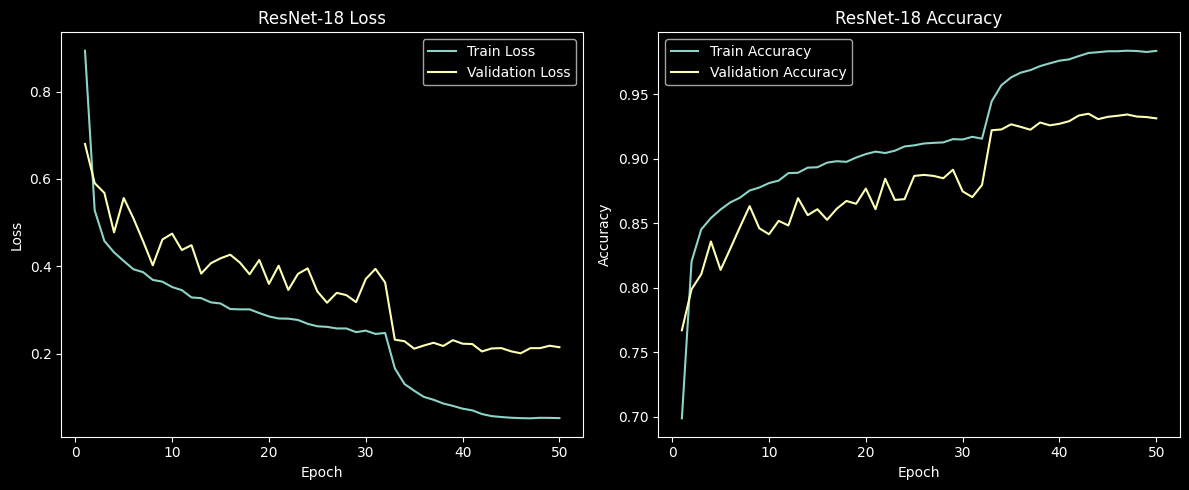

In [21]:
# Plot Loss
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(epochs, train_losses_resnet, label='Train Loss')
plt.plot(epochs, val_losses_resnet, label='Validation Loss')
plt.title('ResNet-18 Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

# Plot Accuracy
plt.subplot(1, 2, 2)
plt.plot(epochs, train_accuracies_resnet, label='Train Accuracy')
plt.plot(epochs, val_accuracies_resnet, label='Validation Accuracy')
plt.title('ResNet-18 Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()


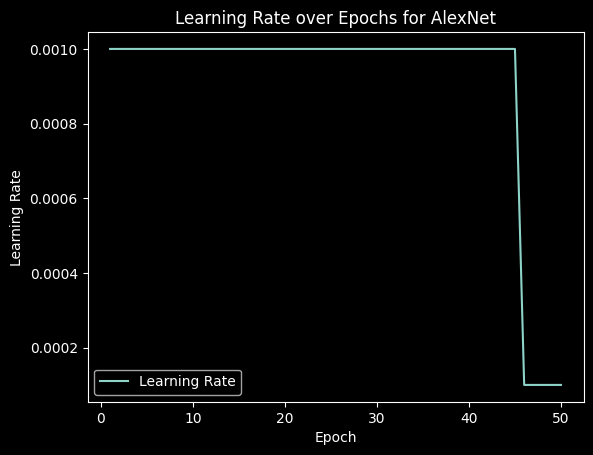

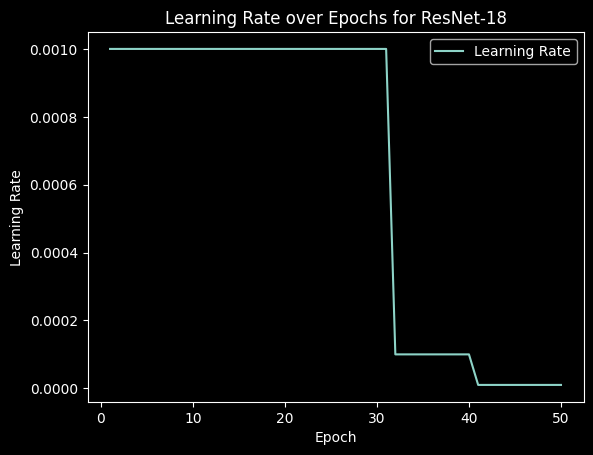

In [22]:
# Plot Learning Rate Changes for AlexNet
plt.figure()
plt.plot(epochs, lr_rates_alexnet, label='Learning Rate')
plt.title('Learning Rate over Epochs for AlexNet')
plt.xlabel('Epoch')
plt.ylabel('Learning Rate')
plt.legend()
plt.show()

# Plot Learning Rate Changes for ResNet-18
plt.figure()
plt.plot(epochs, lr_rates_resnet, label='Learning Rate')
plt.title('Learning Rate over Epochs for ResNet-18')
plt.xlabel('Epoch')
plt.ylabel('Learning Rate')
plt.legend()
plt.show()

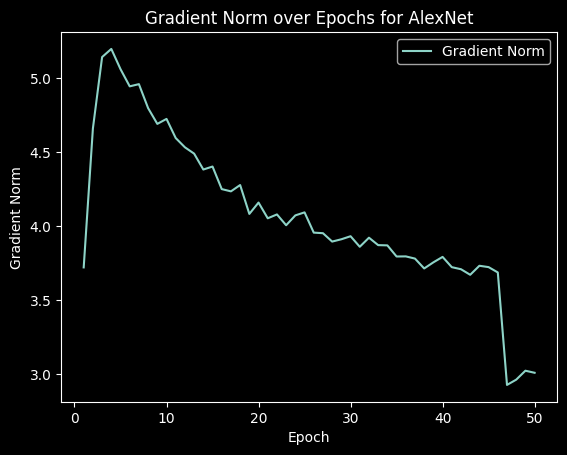

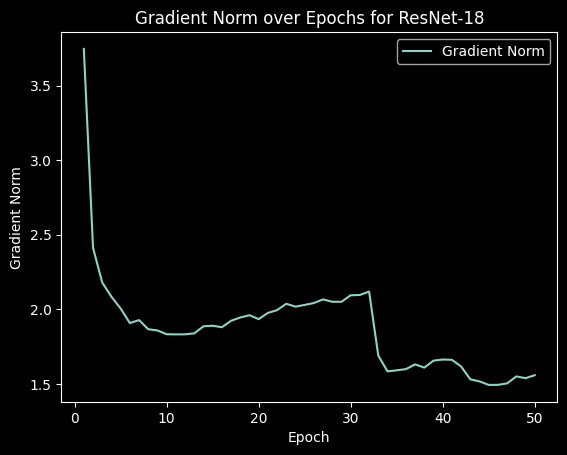

In [23]:
# Plot Gradient Norms for AlexNet
plt.figure()
plt.plot(epochs, grad_norms_alexnet, label='Gradient Norm')
plt.title('Gradient Norm over Epochs for AlexNet')
plt.xlabel('Epoch')
plt.ylabel('Gradient Norm')
plt.legend()
plt.show()

# Plot Gradient Norms for ResNet-18
plt.figure()
plt.plot(epochs, grad_norms_resnet, label='Gradient Norm')
plt.title('Gradient Norm over Epochs for ResNet-18')
plt.xlabel('Epoch')
plt.ylabel('Gradient Norm')
plt.legend()
plt.show()


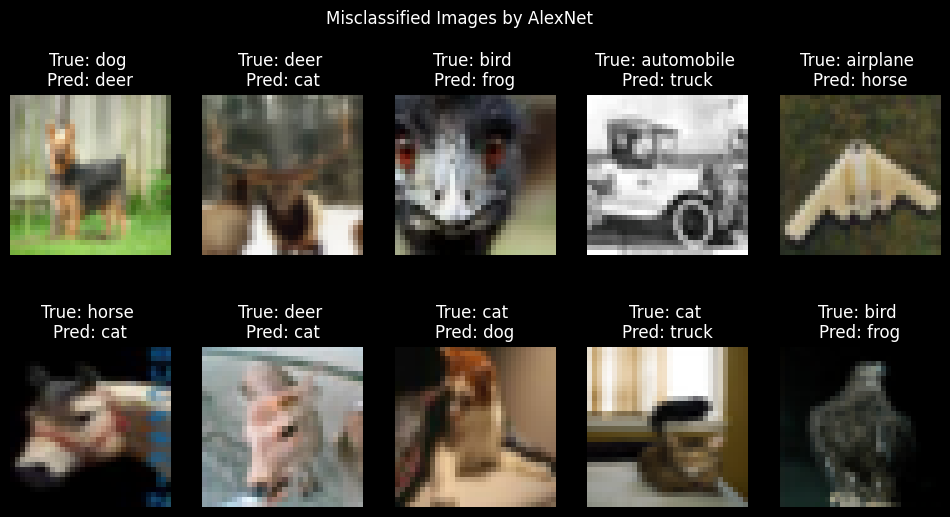

In [24]:
#  Display Misclassified Images for Alexnet
misclassified_indices = []
alexnet.eval()
with torch.no_grad():
    for inputs, labels in test_loader:
        inputs = inputs.to(device)
        outputs = alexnet(inputs)
        _, preds = outputs.max(1)
        preds = preds.cpu()
        for idx in range(len(preds)):
            if preds[idx] != labels[idx]:
                misclassified_indices.append((inputs[idx].cpu(), labels[idx], preds[idx]))
        if len(misclassified_indices) >= 10:  # Collect 10 misclassified images
            break

# Display misclassified images for AlexNet
fig = plt.figure(figsize=(12, 6))
for i in range(10):
    img, true_label, pred_label = misclassified_indices[i]
    fig.add_subplot(2, 5, i+1)
    imshow(img, mean, std)
    plt.title(f'True: {class_names[true_label]} \nPred: {class_names[pred_label]}')
plt.suptitle('Misclassified Images by AlexNet')
plt.show()

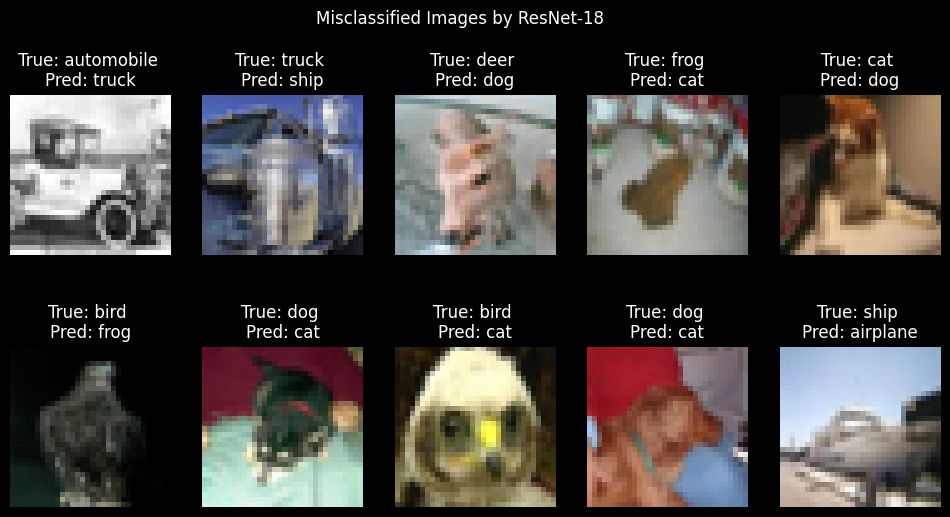

In [25]:
#  Display Misclassified Images for ResNet-18
# ----------------------------
misclassified_indices_resnet = []
resnet18.eval()
with torch.no_grad():
    for inputs, labels in test_loader:
        inputs = inputs.to(device)
        outputs = resnet18(inputs)
        _, preds = outputs.max(1)
        preds = preds.cpu()
        for idx in range(len(preds)):
            if preds[idx] != labels[idx]:
                misclassified_indices_resnet.append((inputs[idx].cpu(), labels[idx], preds[idx]))
        if len(misclassified_indices_resnet) >= 10:  # Collect 10 misclassified images
            break

# Display misclassified images for ResNet-18
fig = plt.figure(figsize=(12, 6))
for i in range(10):
    img, true_label, pred_label = misclassified_indices_resnet[i]
    fig.add_subplot(2, 5, i+1)
    imshow(img, mean, std)
    plt.title(f'True: {class_names[true_label]} \nPred: {class_names[pred_label]}')
plt.suptitle('Misclassified Images by ResNet-18')
plt.show()

In [26]:
# Count parameters in AlexNet
alexnet_params = sum(p.numel() for p in alexnet.parameters() if p.requires_grad)
print(f'Number of trainable parameters in AlexNet: {alexnet_params}')

# Count parameters in ResNet-18
resnet_params = sum(p.numel() for p in resnet18.parameters() if p.requires_grad)
print(f'Number of trainable parameters in ResNet-18: {resnet_params}')

Number of trainable parameters in AlexNet: 35855178
Number of trainable parameters in ResNet-18: 11173962


In [27]:
# Classification Report for AlexNet
print('Classification Report for AlexNet:')
print(classification_report(y_true_alexnet, y_pred_alexnet, target_names=class_names))

# Classification Report for ResNet-18
print('Classification Report for ResNet-18:')
print(classification_report(y_true_resnet, y_pred_resnet, target_names=class_names))

Classification Report for AlexNet:
              precision    recall  f1-score   support

    airplane       0.90      0.88      0.89      1000
  automobile       0.94      0.95      0.94      1000
        bird       0.88      0.81      0.85      1000
         cat       0.75      0.74      0.75      1000
        deer       0.88      0.87      0.88      1000
         dog       0.81      0.81      0.81      1000
        frog       0.87      0.94      0.90      1000
       horse       0.91      0.91      0.91      1000
        ship       0.92      0.94      0.93      1000
       truck       0.91      0.94      0.92      1000

    accuracy                           0.88     10000
   macro avg       0.88      0.88      0.88     10000
weighted avg       0.88      0.88      0.88     10000

Classification Report for ResNet-18:
              precision    recall  f1-score   support

    airplane       0.93      0.94      0.94      1000
  automobile       0.96      0.97      0.97      1000
      